In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
#from matplotlib import rcParam
import seaborn as sb
import os
import sys
sys.setrecursionlimit(1000000)
from scipy.stats import spearmanr
import pathlib
import scipy as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache()
from scipy.stats import pearsonr
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import scanpy as sc
import anndata as ad

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/camp/home/turnerb/.conda/envs/MAPseq_proces

In [2]:
from matplotlib import rcParams
#for_binary_barcode_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq/Final_processed_sequences/filtered_barcode_matrix_for_binary_junk_test.pkl')
#normalised_barcode_path_junk_test = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq/Final_processed_sequences/barcode_matrix_normalised_junk_test.pkl')
normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/Source_target_together/source_filtered_thresholded_all_source.pkl')
#normalised_barcode_path= pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_MAPseq/A1_MAPseq/FIAA32.6a/Sequencing/Processed_data/UpdatedApril/preprocessed_seq_corrected/Final_processed_sequences/barcode_matrix_normalised.pkl')
lcm_reg_dir = pathlib.PurePath('/nemo/lab/znamenskiyp/home/shared/code/MAPseq_processing/AC_MAPseq/Brain1_FIAA32.6a/LCM_registration')
areas = pd.read_csv(lcm_reg_dir/'3d_areas.csv')
RTtosample = pd.read_csv(lcm_reg_dir/'RTprimer_tosample.csv')
# areas = areas.merge(RTtosample, how='inner', on='sample')
#areas.sort_values("RT_primer", inplace=True)





In [3]:
#load barcodes, and drop samples that have been qc'd out
barcodes_across_sample = pd.read_pickle(normalised_barcode_path)

areas =areas[areas['sample'].isin(barcodes_across_sample.columns)]

In [9]:
#drop columns that are zero in all values
#barcodes_matrix = barcodes_across_sample.loc[:, (barcodes_across_sample != 0).any(axis=0)]

In [4]:
all_areas_fractions = pd.DataFrame(index=barcodes_across_sample.columns)
all_areas_fractions['name'] = 'string'
areas_to_look = areas.set_index('sample')
for i, row in areas_to_look.iterrows():
    row /= row.sum(0)
    
    if row[row.idxmax()]>0.9999:
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2))
    else:
        second_highest_row = row.drop(row.idxmax())
        name= str(row.idxmax()) + ' ' + str(row[row.idxmax()].round(2)) + ' ' + str(second_highest_row.idxmax()) + ' ' + str(row[second_highest_row.idxmax()].round(2))
    all_areas_fractions.loc[i] = name
    

In [5]:
barcodes_across_sample_renamed = barcodes_across_sample.copy()
new_columns= {}
for val in barcodes_across_sample_renamed.columns:
    new_columns[val]= all_areas_fractions.loc[val]['name'] #create a dictionary to rename columns in the barcode matrix with tube names rather than RT sample names
barcodes_across_sample_renamed = barcodes_across_sample_renamed.rename(columns=new_columns)

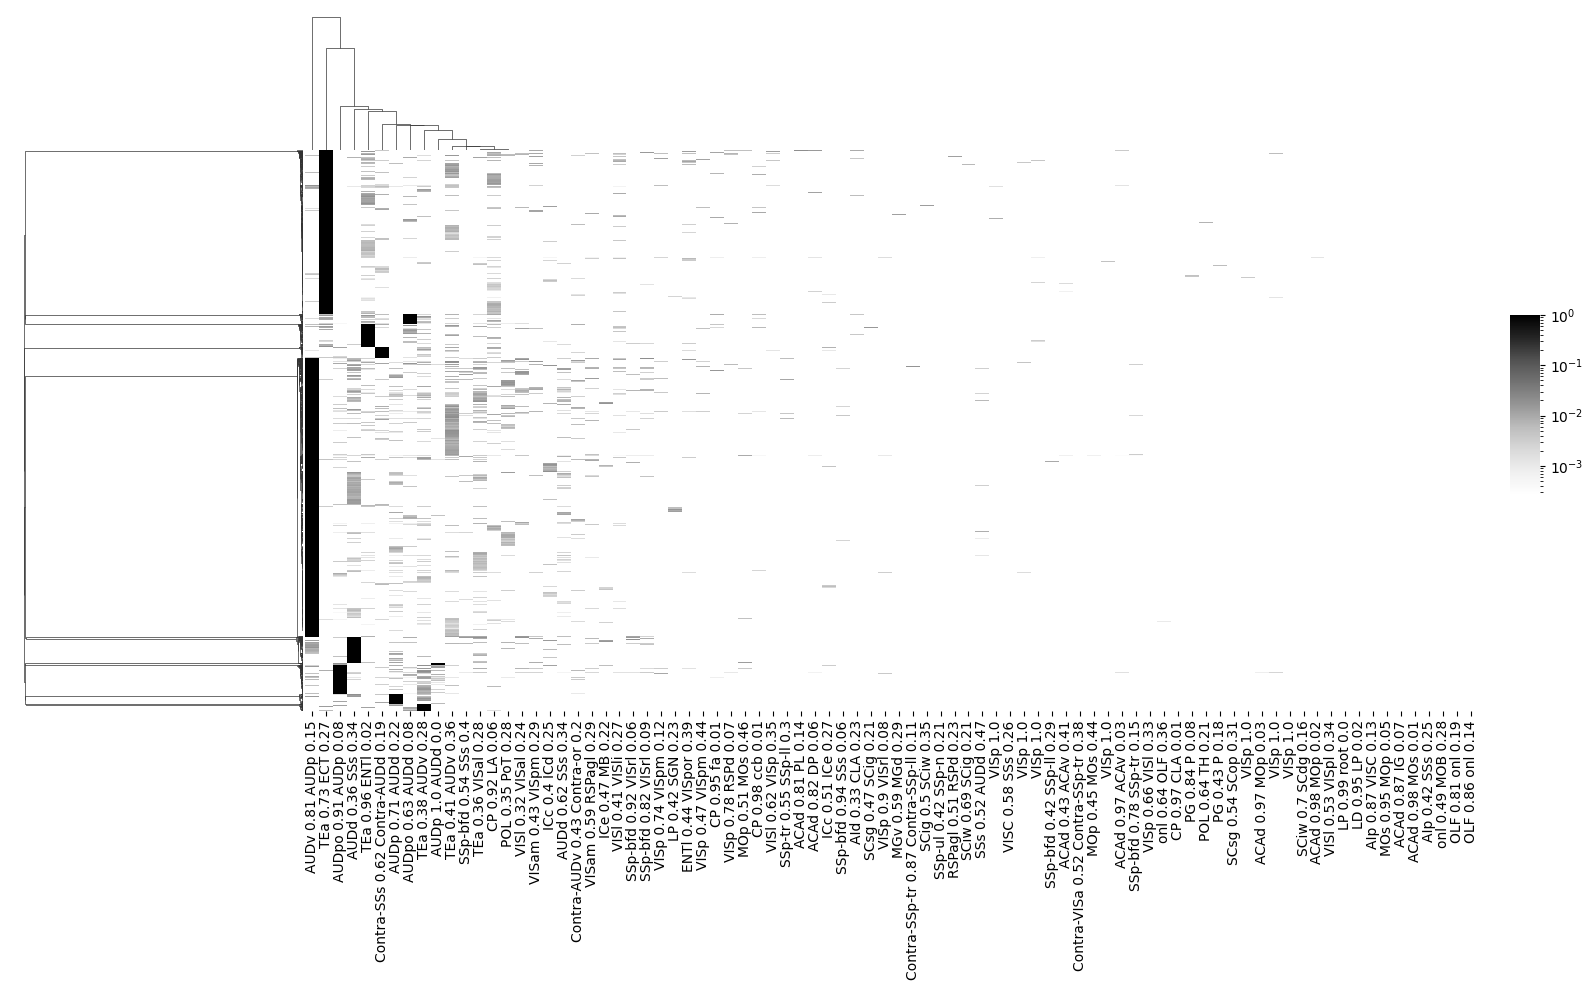

In [6]:
barcodes_across_sample_renamed =barcodes_across_sample_renamed.reset_index(drop=True)
sb.clustermap(barcodes_across_sample_renamed, metric='euclidean', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(15, 10), xticklabels=1 ,yticklabels=False, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [13]:
barcodes_no_source = barcodes_across_sample_renamed.drop(columns =['AUDv 0.81 AUDp 0.15','AUDp 0.71 AUDd 0.22', 'AUDp 1.0 AUDd 0.0', 'AUDd 0.62 SSs 0.34', 'TEa 0.41 AUDv 0.36'])

In [14]:
barcodes_no_source = barcodes_no_source.loc[:, (barcodes_no_source != 0).any(axis=0)]

In [15]:
barcodes_no_source = barcodes_no_source.loc[~(barcodes_no_source == 0).all(axis=1)]

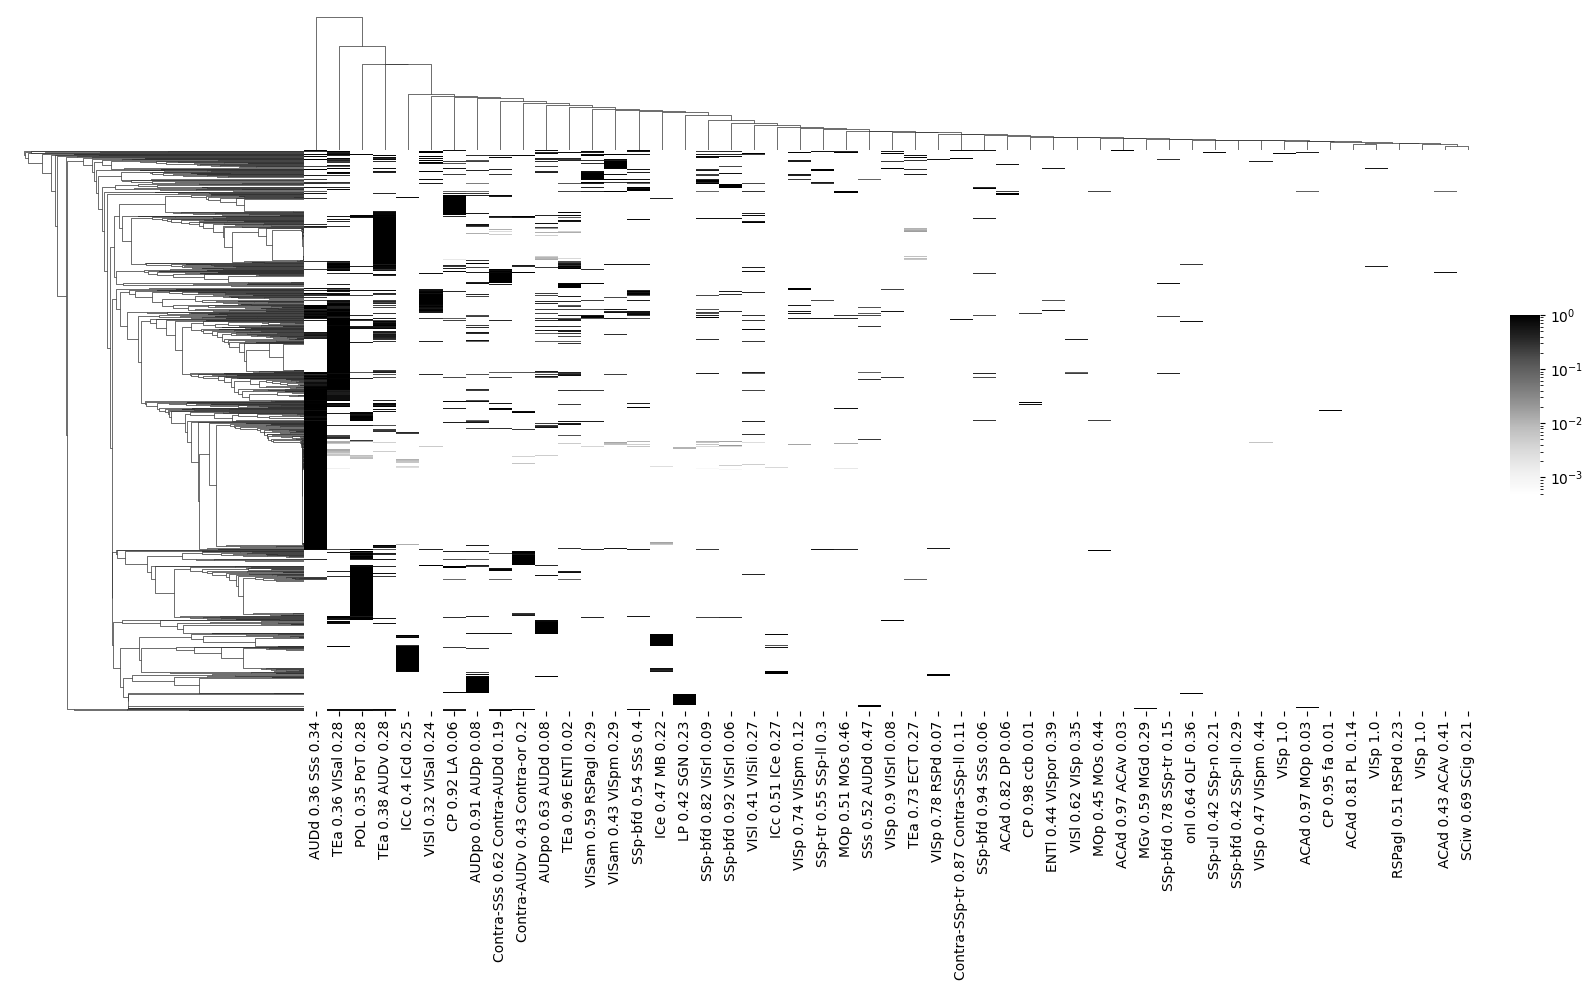

In [16]:

sb.clustermap(barcodes_no_source, metric='euclidean', standard_scale=0, norm=LogNorm(), cmap="Greys", figsize=(15, 10), xticklabels=1 ,yticklabels=False, cbar_pos=(1.01, 0.5, 0.02, 0.18))

In [31]:
barcodes_across_sample_renamed.max(axis=1)

sequence
CATGCTTTATCTTTATATTGTGCACATGACTC    4645.426814
AATTATTGTTGTGTTATCCAGCTCAACCCCCT    1200.823989
CTTCCCAAACACTCGTCTCCATTACTTCACCT    1704.986732
TCTTCTGCAACTGAGTTCAACTTTGTTCAGCT    1828.226514
GGCACAGGGCCATATGTATGGACAAACTCTTT     666.105928
                                       ...     
TTATTTGTCCGCCGGATGACATTTTACATCCT     701.753798
ATCCATGTAGTATCCCACTGGGCCTATACATT     282.127434
AGGAGCTTTCATATTAAGCCTCCACCTCGGTT     357.888073
AGGAATCCCCAACGTACCTGCGAGCGAATGTT     300.460625
TGTATTGGCCCTAGTCTTCTAACTTTGGATCT     269.905307
Length: 1430, dtype: float64

In [8]:
barcodes_normalised_no_source = barcodes_across_sample_renamed.div(barcodes_across_sample_renamed.max(axis=1), axis=0)

In [19]:
normalised_with_source = barcodes_across_sample_renamed.div(barcodes_across_sample_renamed.max(axis=1), axis=0)

In [20]:
barcodes_across_sample_renamed

,onl 0.64 OLF 0.36,OLF 0.81 onl 0.19,OLF 0.86 onl 0.14,onl 0.49 MOB 0.28,ACAd 0.81 PL 0.14,ACAd 0.97 MOp 0.03,CP 0.95 fa 0.01,AId 0.33 CLA 0.23,ACAd 0.82 DP 0.06,ACAd 0.97 ACAv 0.03,...,SCiw 0.7 SCdg 0.16,PG 0.43 P 0.18,RSPagl 0.51 RSPd 0.23,VISp 1.0,VISp 1.0,VISp 1.0,VISp 0.66 VISl 0.33,ICe 0.47 MB 0.22,ICc 0.51 ICe 0.27,ICc 0.4 ICd 0.25
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.030344,1.511072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.626345,0.0,0.0,4.030344,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1426,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1427,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1428,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
barcodes_normalised_no_source

,onl 0.64 OLF 0.36,OLF 0.81 onl 0.19,OLF 0.86 onl 0.14,onl 0.49 MOB 0.28,ACAd 0.81 PL 0.14,ACAd 0.97 MOp 0.03,CP 0.95 fa 0.01,AId 0.33 CLA 0.23,ACAd 0.82 DP 0.06,ACAd 0.97 ACAv 0.03,...,SCiw 0.7 SCdg 0.16,PG 0.43 P 0.18,RSPagl 0.51 RSPd 0.23,VISp 1.0,VISp 1.0,VISp 1.0,VISp 0.66 VISl 0.33,ICe 0.47 MB 0.22,ICc 0.51 ICe 0.27,ICc 0.4 ICd 0.25
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000868,0.000325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000828,0.0,0.001252,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000523
3,0.0,0.0,0.0,0.0,0.0,0.000812,0.000000,0.0,0.000671,0.001509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002076,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2475,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2476,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2477,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2478,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [21]:
#now drop source columns
barcodes_normalised_no_source = barcodes_normalised_no_source.loc[:, (barcodes_normalised_no_source != 1).all()]

#remove maximum values of source sites for clustering
#barcodes_normalised_no_source = barcodes_normalised.replace(1, 0)

In [22]:
barcodes_normalised_no_source= barcodes_normalised_no_source.loc[:, (barcodes_normalised_no_source != 0).any(axis=0)]

In [23]:
barcodes_normalised_no_source = barcodes_normalised_no_source.loc[~(barcodes_normalised_no_source == 0).all(axis=1)]

In [24]:
barcodes_normalised_no_source

,onl 0.64 OLF 0.36,ACAd 0.81 PL 0.14,ACAd 0.97 MOp 0.03,CP 0.95 fa 0.01,ACAd 0.82 DP 0.06,ACAd 0.97 ACAv 0.03,MOp 0.45 MOs 0.44,ACAd 0.43 ACAv 0.41,MOp 0.51 MOs 0.46,SSp-ul 0.42 SSp-n 0.21,...,VISp 1.0,Contra-AUDv 0.43 Contra-or 0.2,VISp 0.78 RSPd 0.07,ENTl 0.44 VISpor 0.39,SCiw 0.69 SCig 0.21,RSPagl 0.51 RSPd 0.23,VISp 1.0,ICe 0.47 MB 0.22,ICc 0.51 ICe 0.27,ICc 0.4 ICd 0.25
0,0.0,0.0,0.000000,0.0,0.000868,0.000325,0.000730,0.000724,0.009277,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.001354,0.0,0.003356,0.000000,0.002824,0.001121,0.014356,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001264,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.001705,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.006470,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1422,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1423,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.011269
1425,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [25]:
# kmeans_labels = cluster.KMeans(n_clusters=6).fit_predict(barcodes_normalised_no_source)

In [26]:
# Kmean = cluster.KMeans(n_clusters=3)
# Kmean.fit(barcodes_no_source)

In [27]:
reducer = umap.UMAP()

In [28]:
scaled_barcode_data = StandardScaler().fit_transform(barcodes_normalised_no_source)

In [29]:
embedding = reducer.fit_transform(scaled_barcode_data)
embedding.shape

(1210, 2)

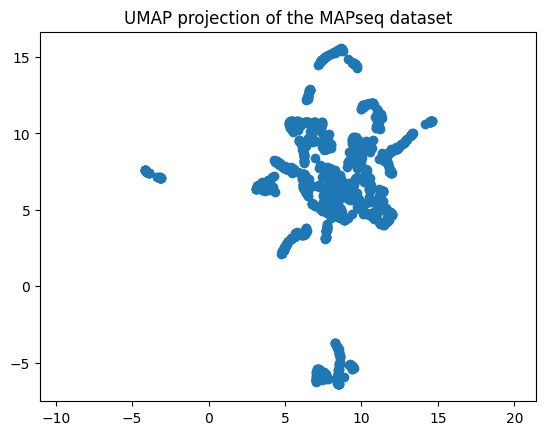

In [30]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the MAPseq dataset', fontsize=12);

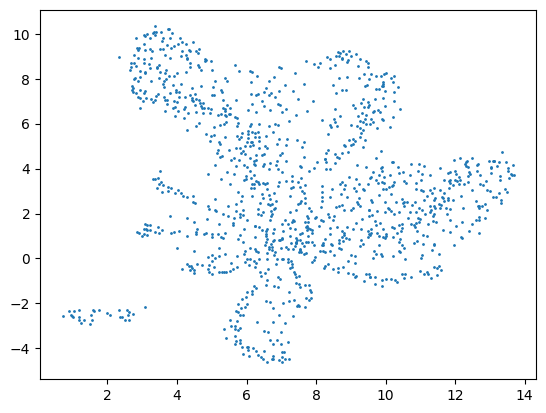

In [31]:
clusterable_embedding = umap.UMAP(
    n_neighbors=100,
    min_dist=0.7,
    n_components=2,
    
).fit_transform(barcodes_normalised_no_source)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=1
            );

In [32]:
labels = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=10,
).fit_predict(clusterable_embedding)

In [33]:
np.unique(labels)

array([0, 1])

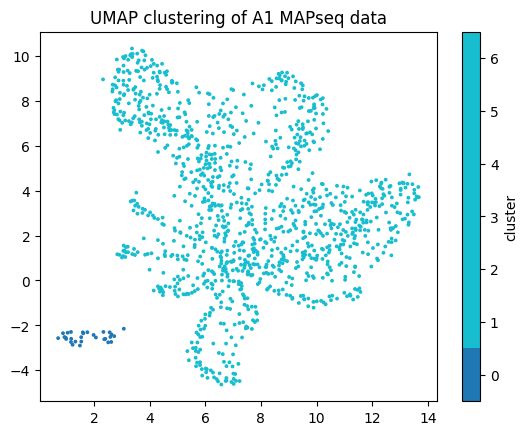

In [34]:
clustered = (labels >= 0)
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=3,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=3,
            cmap='tab10');

plt.title('UMAP clustering of A1 MAPseq data')
plt.colorbar(ticks = [0,1,2, 3, 4, 5, 6], values = [0,1,2, 3, 4, 5, 6], label='cluster')     

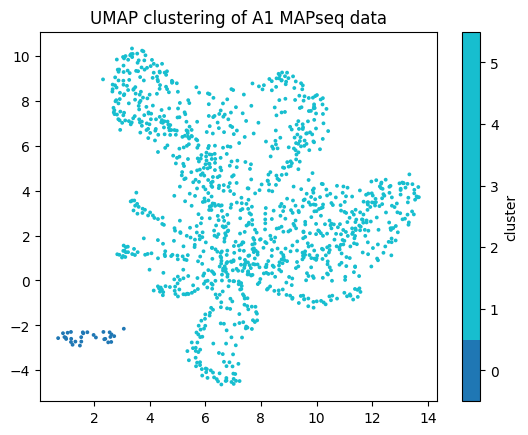

In [35]:
clustered = (labels >= 0)
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=3,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=3,
            cmap='tab10');

plt.title('UMAP clustering of A1 MAPseq data')
plt.colorbar(ticks = [0,1,2, 3, 4, 5], values = [0,1,2, 3, 4, 5], label='cluster')          

In [36]:
#redo clustering with sample numbers rather than area names
barcodes_normalised = barcodes_across_sample.div(barcodes_across_sample.max(axis=1), axis=0)

In [37]:
#now drop source columns
barcodes_normalised_no_source = barcodes_normalised.loc[:, (barcodes_normalised != 1).all()]

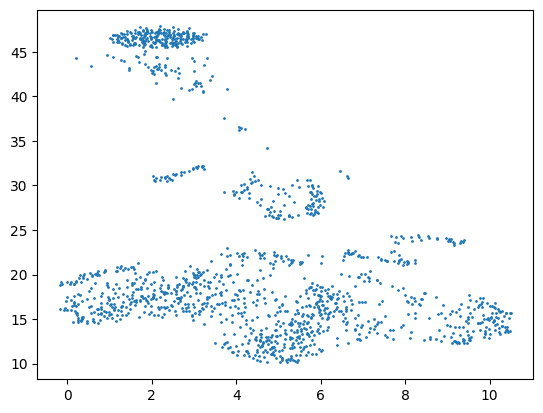

In [38]:
clusterable_embedding = umap.UMAP(
    n_neighbors=100,
    min_dist=0.7,
    n_components=2,
    
).fit_transform(barcodes_normalised_no_source)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=1
            );

In [39]:
labels = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=10,
).fit_predict(clusterable_embedding)

In [40]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5])

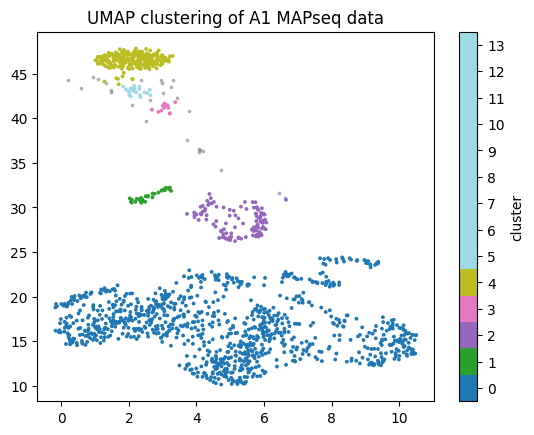

In [41]:
clustered = (labels >= 0)
clustered = (labels >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=3,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=3,
            cmap='tab20');

plt.title('UMAP clustering of A1 MAPseq data')
plt.colorbar(ticks = [0,1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], values = [0,1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], label='cluster')     

In [42]:
barcodes_normalised_no_source['labels'] = labels
barcodes_normalised_no_source =barcodes_normalised_no_source.set_index('labels')


/tmp/ipykernel_194474/3657034106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barcodes_normalised_no_source['labels'] = labels


In [43]:
barcodes_normalised


,1,2,3,4,6,7,8,9,10,11,...,93,80,81,82,83,84,85,86,89,90
sequence,,,,,,,,,,,,,,,,,,,,,
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000868,0.000325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AATTATTGTTGTGTTATCCAGCTCAACCCCCT,0.0,0.0,0.0,0.0,0.0,0.001354,0.0,0.0,0.003356,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTTCCCAAACACTCGTCTCCATTACTTCACCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCTTCTGCAACTGAGTTCAACTTTGTTCAGCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCACAGGGCCATATGTATGGACAAACTCTTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTATTTGTCCGCCGGATGACATTTTACATCCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATCCATGTAGTATCCCACTGGGCCTATACATT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGGAGCTTTCATATTAAGCCTCCACCTCGGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
barcodes_normalised_no_source.to_pickle(normalised_barcode_path.parents[0]/'barcodes_with_cluster_label.pkl')

In [45]:
#also save a copy with source sites
barcodes_normalised['labels'] = labels
barcodes_normalised =barcodes_normalised.set_index('labels')
barcodes_normalised.to_pickle(normalised_barcode_path.parents[0]/'barcodes_with_cluster_label_with_source.pkl')

In [ ]:
barcodes_normalised_no_source =barcodes_normalised_no_source.set_index('labels')

Lets use scampy to perform clustering using leiden algorithm

In [10]:
#drop the thalamus samples
barcodes_across_sample_no_thal = barcodes_across_sample.drop([44, 30, 54, 56, 66, 67], axis=1)

In [18]:
normalised_with_source = barcodes_across_sample_no_thal.div(barcodes_across_sample_no_thal.max(axis=1), axis=0)

In [36]:
#now look only at the barcodes with max barcode count ipsi auditory regions and A1
A1_and_TEA = [35, 36, 42, 43, 51, 53, 65]
source_thresholded = normalised_with_source[normalised_with_source.idxmax(axis=1).isin(A1_and_TEA)]

In [37]:
normalised_with_source.loc[:, (normalised_with_source != 1).all()]

,1,2,3,4,6,7,8,9,10,11,...,93,80,81,82,83,84,85,86,89,90
sequence,,,,,,,,,,,,,,,,,,,,,
TCGAGAATGTGTGTACCAGGCTCTTGTCGCTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000868,0.000325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
TTGTTTAGATAGTTTGTACCTGTGCGTCGGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000828,0.0,0.001252,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000523
GATGGGTGTGTACTCGACCTGATGTTTTTACT,0.0,0.0,0.0,0.0,0.0,0.000812,0.000000,0.0,0.000671,0.001509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
GATCTCGAATGCAATTCTGACTCACCAAGTTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002076,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCCATGTAGTATCCCACTGGGCCTATACATT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AGGAGCTTTCATATTAAGCCTCCACCTCGGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AGGAATCCCCAACGTACCTGCGAGCGAATGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [38]:
#now drop source columns
barcodes_normalised_no_source = source_thresholded.loc[:, (source_thresholded != 1).all()]

In [35]:
barcodes_normalised_no_source

,1,2,3,4,6,7,8,9,10,11,...,93,80,81,82,83,84,85,86,89,90
sequence,,,,,,,,,,,,,,,,,,,,,
TCGAGAATGTGTGTACCAGGCTCTTGTCGCTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,4.030344,1.511072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
TTGTTTAGATAGTTTGTACCTGTGCGTCGGTT,0.0,0.0,0.0,0.0,0.0,0.000000,2.221643,0.0,3.358620,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.402328
AATTATTGTTGTGTTATCCAGCTCAACCCCCT,0.0,0.0,0.0,0.0,0.0,1.626345,0.000000,0.0,4.030344,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
TTGTCGTGACACCGCAGAATGTGTTTCGAGTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATCCATGTAGTATCCCACTGGGCCTATACATT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AGGAGCTTTCATATTAAGCCTCCACCTCGGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
AGGAATCCCCAACGTACCTGCGAGCGAATGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [39]:
adata = sc.AnnData(barcodes_normalised_no_source, 
    barcodes_normalised_no_source.index.to_frame(), 
    barcodes_normalised_no_source.columns.to_frame())

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [40]:
dataset =ad.AnnData(barcodes_normalised_no_source)

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


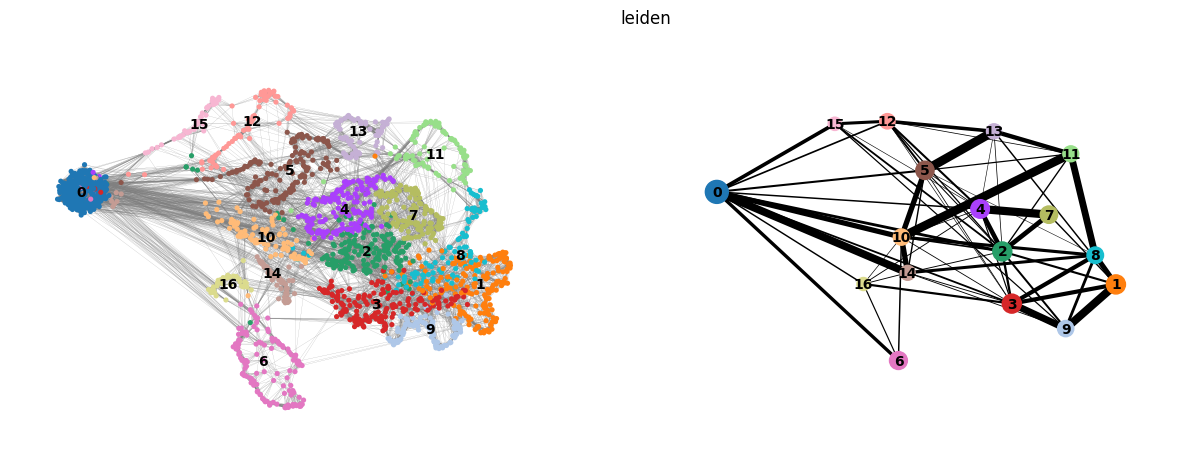

In [41]:
sc.tl.pca(dataset)
sc.pp.neighbors(dataset)
sc.tl.umap(dataset, spread=0.8)
sc.tl.leiden(dataset)
sc.tl.paga(dataset)
sc.pl.paga_compare(dataset, edges=True, threshold=0.05)

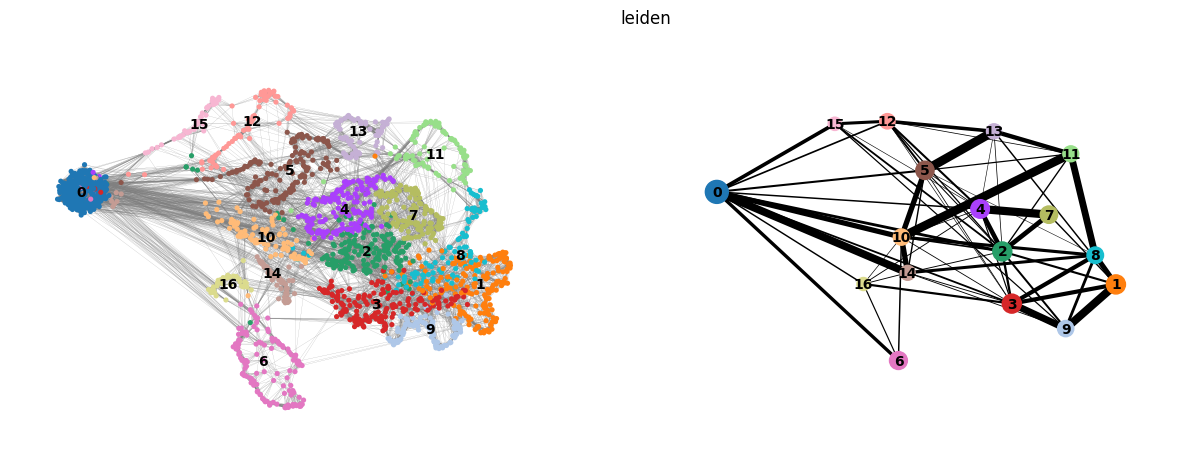

In [43]:
sc.pl.paga_compare(dataset, edges=True, threshold=0.05)

In [44]:
sc.tl.leiden(dataset, key_added = "leiden_1.0") 

In [45]:
sc.tl.leiden(dataset, resolution = 0.6, key_added = "leiden_0.6")
sc.tl.leiden(dataset, resolution = 0.4, key_added = "leiden_0.4")
sc.tl.leiden(dataset, resolution = 1.4, key_added = "leiden_1.4")

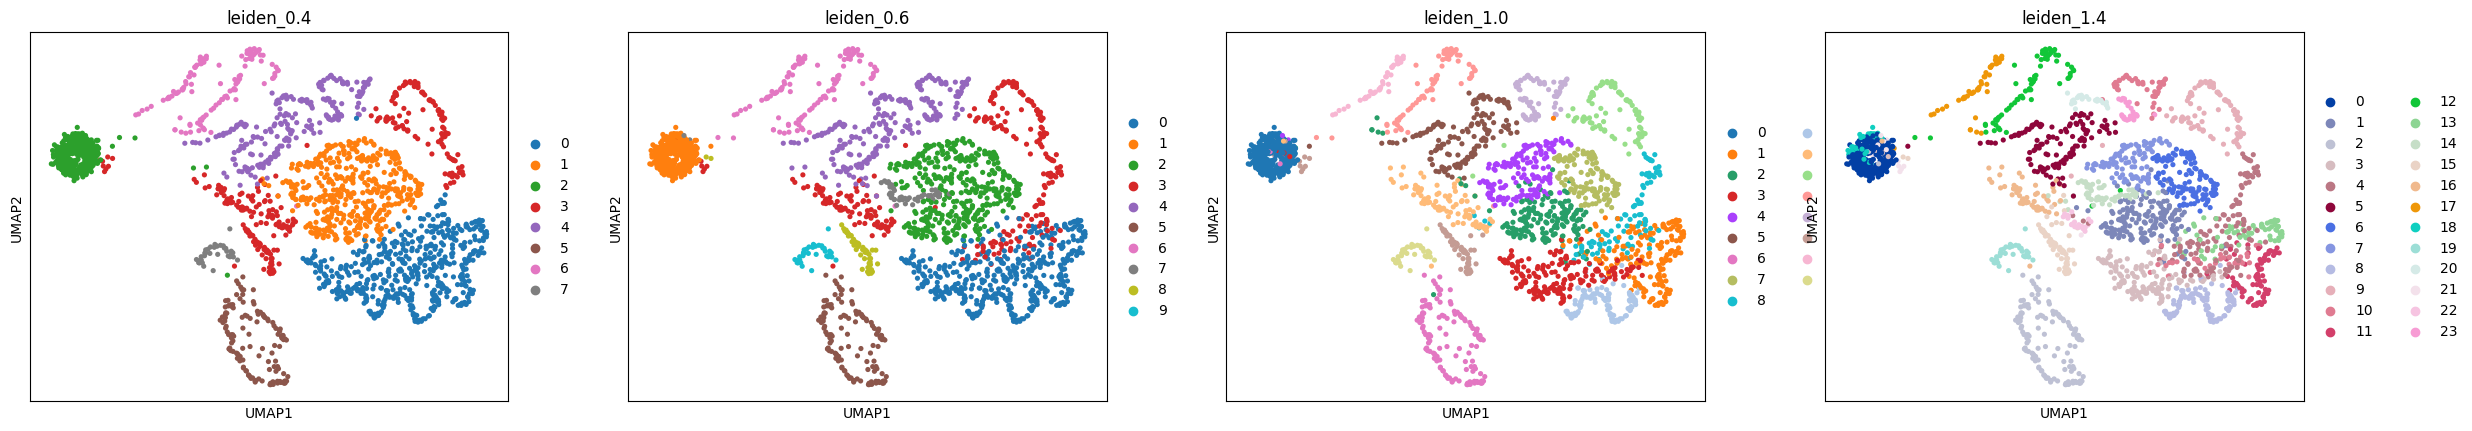

In [46]:
sc.pl.umap(dataset, color=['leiden_0.4', 'leiden_0.6', 'leiden_1.0','leiden_1.4'])

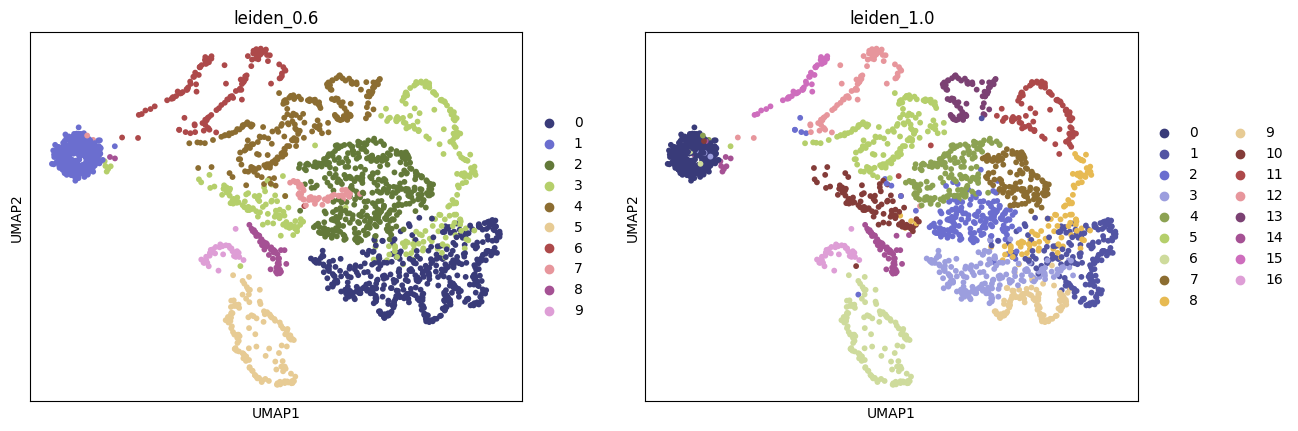

In [47]:
sc.pl.umap(dataset, color=['leiden_0.6', 'leiden_1.0'], palette='tab20b', s=70)

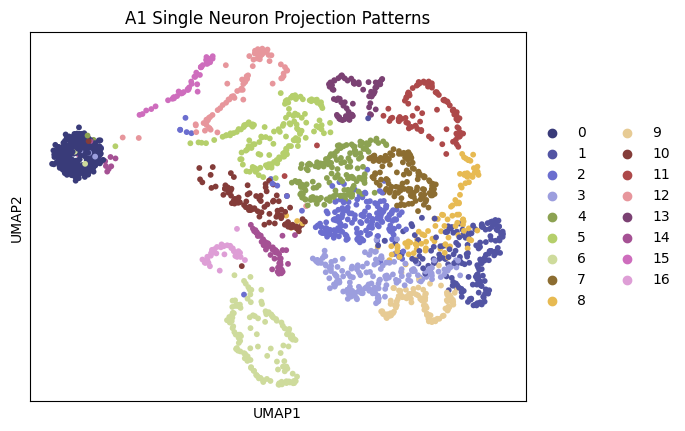

In [48]:
sc.pl.umap(dataset, color=['leiden_1.0'], palette='tab20b', s=70, title='A1 Single Neuron Projection Patterns')


In [19]:
leiden_categories = pd.DataFrame(dataset.obs['leiden_1.0'])

In [254]:
leiden_categories['leiden_1.0']=='1'

sequence
CATGCTTTATCTTTATATTGTGCACATGACTC     True
AATTATTGTTGTGTTATCCAGCTCAACCCCCT    False
CTTCCCAAACACTCGTCTCCATTACTTCACCT    False
TCTTCTGCAACTGAGTTCAACTTTGTTCAGCT     True
GGCACAGGGCCATATGTATGGACAAACTCTTT    False
                                    ...  
TTATTTGTCCGCCGGATGACATTTTACATCCT     True
ATCCATGTAGTATCCCACTGGGCCTATACATT    False
AGGAGCTTTCATATTAAGCCTCCACCTCGGTT    False
AGGAATCCCCAACGTACCTGCGAGCGAATGTT    False
TGTATTGGCCCTAGTCTTCTAACTTTGGATCT    False
Name: leiden_1.0, Length: 1430, dtype: bool

In [21]:
barcodes_across_sample_renamed_1 = barcodes_across_sample_renamed.copy()
barcodes_across_sample_renamed_1['leiden'] = leiden_categories['leiden_1.0']

In [40]:
df = barcodes_across_sample_renamed[leiden_categories['leiden_1.0']=='1']
df = df.loc[:, (df != 0).any(axis=0)]
df.loc[:, (df != 0).any(axis=0)]

,onl 0.64 OLF 0.36,ACAd 0.81 PL 0.14,ACAd 0.82 DP 0.06,ACAd 0.97 ACAv 0.03,MOp 0.45 MOs 0.44,ACAd 0.43 ACAv 0.41,MOp 0.51 MOs 0.46,CP 0.98 ccb 0.01,SSp-tr 0.55 SSp-ll 0.3,SSp-bfd 0.78 SSp-tr 0.15,...,VISp 0.47 VISpm 0.44,VISp 1.0,VISl 0.62 VISp 0.35,VISl 0.41 VISli 0.27,TEa 0.96 ENTl 0.02,TEa 0.73 ECT 0.27,Contra-AUDv 0.43 Contra-or 0.2,ENTl 0.44 VISpor 0.39,RSPagl 0.51 RSPd 0.23,ICe 0.47 MB 0.22
sequence,,,,,,,,,,,,,,,,,,,,,
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,4.030344,1.511072,3.391568,3.365269,43.096774,2.180007,0.00000,1.595809,...,0.000000,0.0,0.0,1.789286,3.103684,0.000000,0.000000,0.000000,0.0,0.0
TCTTCTGCAACTGAGTTCAACTTTGTTCAGCT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.180007,0.00000,0.000000,...,5.760363,0.0,0.0,0.000000,4.345158,0.000000,0.000000,3.117917,0.0,0.0
GGTCCCTGTCACCTTGCGTATGCGTCGCTGTT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.41788,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4.068818,0.000000,0.0,0.0
TTTGTTCGTCCAGTCGTGTGGTTCTTGGGTCT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,1.789286,3.103684,0.000000,0.000000,0.000000,0.0,0.0
TCCAAGCGCCTGTGCCTCGCAGGCCCAGCTCT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,2.897423,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAGATTTCGTTTGATGGAGTATTTAATGCCTT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
GTTTCAATAAGCACCGATTCAAGGATCTTGTT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
GAGTGGCGTCGGATTGTCTACTACGAGGGCCT,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
barcodes_across_sample_renamed_1

In [37]:
normalised_with_source['leiden'] = leiden_categories['leiden_1.0']

In [38]:
normalised_with_source = normalised_with_source.set_index('leiden')

In [39]:
normalised_with_source.to_pickle(normalised_barcode_path.parents[0]/'barcodes_with_leiden_cluster_label_with_source.pkl')

Lets try to cluster visual areas only

In [14]:
all_areas_fractions_vis =all_areas_fractions[all_areas_fractions['name'].str.contains('VIS')]
all_areas_fractions_vis = all_areas_fractions_vis[~all_areas_fractions_vis['name'].str.contains('VISC|Contra-VISa|Contra-VISam|Contra-VISC')]

In [23]:
normalised_with_source = barcodes_across_sample.div(barcodes_across_sample.max(axis=1), axis=0)

In [25]:
#now drop source columns
barcodes_normalised_no_source = normalised_with_source.loc[:, (normalised_with_source != 1).all()]

In [26]:
visual_areas_only = barcodes_normalised_no_source[all_areas_fractions_vis.index.values]

In [28]:
dataset =ad.AnnData(visual_areas_only)

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


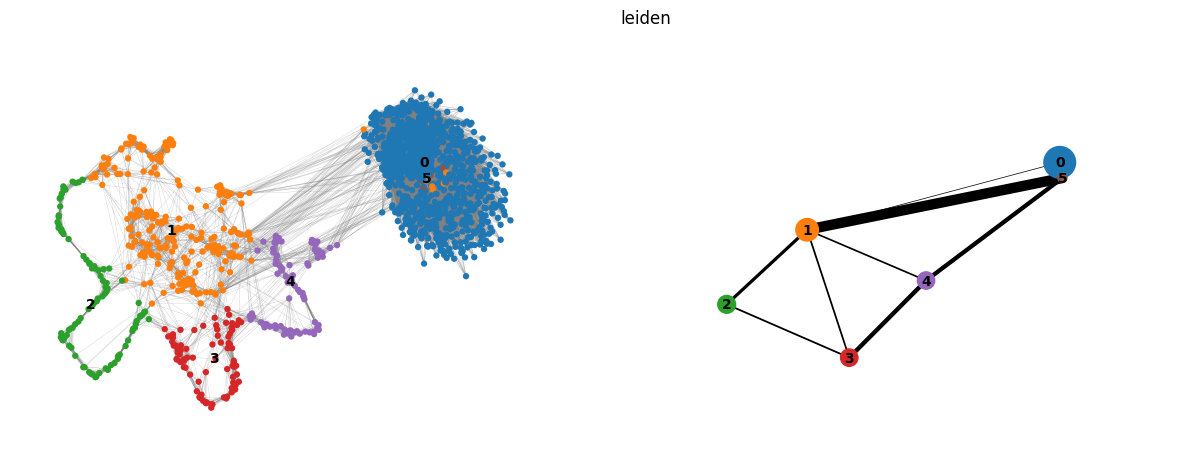

In [30]:
sc.tl.pca(dataset)
sc.pp.neighbors(dataset)
sc.tl.umap(dataset)
sc.tl.leiden(dataset)
sc.tl.paga(dataset)
sc.pl.paga_compare(dataset, edges=True, threshold=0.05)

In [33]:
leiden_categories = pd.DataFrame(dataset.obs['leiden'])

In [34]:
barcodes_across_sample_renamed[leiden_categories['leiden']=='1']

,onl 0.64 OLF 0.36,OLF 0.81 onl 0.19,OLF 0.86 onl 0.14,onl 0.49 MOB 0.28,ACAd 0.81 PL 0.14,ACAd 0.97 MOp 0.03,CP 0.95 fa 0.01,AId 0.33 CLA 0.23,ACAd 0.82 DP 0.06,ACAd 0.97 ACAv 0.03,...,SCiw 0.7 SCdg 0.16,PG 0.43 P 0.18,RSPagl 0.51 RSPd 0.23,VISp 1.0,VISp 1.0,VISp 1.0,VISp 0.66 VISl 0.33,ICe 0.47 MB 0.22,ICc 0.51 ICe 0.27,ICc 0.4 ICd 0.25
sequence,,,,,,,,,,,,,,,,,,,,,
CATGCTTTATCTTTATATTGTGCACATGACTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.030344,1.511072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AATTATTGTTGTGTTATCCAGCTCAACCCCCT,0.0,0.0,0.0,0.0,0.0,1.626345,0.0,0.0,4.030344,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTTCCCAAACACTCGTCTCCATTACTTCACCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCTTCTGCAACTGAGTTCAACTTTGTTCAGCT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCACAGGGCCATATGTATGGACAAACTCTTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGTATCTGTAGAAGGCTGAGTCGGTTGTGATT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GATGATTGCGGCGTCATCTCGTTGCGGGATTC,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCCCCATAAATAGTTTGTGCGTGGGCATGTT,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
